**Задача:**

Нужно понять, стали ли мы больше зарабатывать с пользователя или нет. Вы уже знаете о существовании t-теста, U-теста Mann-Whitney и бутстрапа. Открытый вопрос: какой инструмент использовать?

1. Посчитайте p-value тремя способами: t-тест, U-тест, бутстрап средних

2. Сравните результат между тестом и контролем по всем этим кейсам

3. Напишите выводы, которые можно сделать на основе анализа примененных критериев. Напишите, почему мы должны использовать тот или иной инструмент: каких предположений о случайной величине нужно придерживаться, какие условия необходимы и т.п.

In [1]:
#загузка используемых библиотек
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu,norm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
# загружаем данные в переменную df

df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-lisitsina/lessons/Statistica/hw_bootstrap.csv', sep = ';')

In [3]:
df

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control
...,...,...,...
995,996,1000,Treatment
996,997,1200,Treatment
997,998,1500,Treatment
998,999,2000,Treatment


In [4]:
df = df.drop(columns=df.columns[0])
df

,value,experimentVariant
0,"10,3804953740268",Control
1,"9,54686666784264",Control
2,"11,0882146509904",Control
3,"10,1472740570122",Control
4,"9,78980767524929",Control
...,...,...
995,1000,Treatment
996,1200,Treatment
997,1500,Treatment
998,2000,Treatment


In [5]:
# посмотрим на формат данных
df.dtypes

value                object
experimentVariant    object
dtype: object

In [6]:
# стобец "value" приводим к формату float
df['value'] = df['value'].str.replace(',', '.').astype('float')
df.head()

,value,experimentVariant
0,10.380495,Control
1,9.546867,Control
2,11.088215,Control
3,10.147274,Control
4,9.789808,Control


In [7]:
# фильтруем датафрейм по признаку "experimentVariant"

Test = df[df['experimentVariant'] == 'Treatment'].reset_index(drop=True)['value']

In [8]:
Control = df[df['experimentVariant'] == 'Control']['value']

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


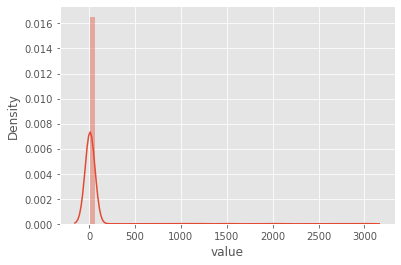

In [9]:
# визуализируем распределение признака в тестовой и конрольной группе
sns.distplot(Test)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


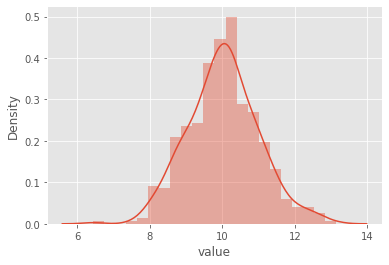

In [10]:
sns.distplot(Control)

Распределение в контрольной группе - нормальное, а в тестовой группе распределение не является нормальным, заметны сильные выбросы.

## Сравниваем тестовую и контрольную группы с помощью t-теста

H0: Группы не различаются

H1: Группы различаются

In [11]:
stats.ttest_ind(Control, Test)

Ttest_indResult(statistic=-2.0729020485356604, pvalue=0.038437593613498765)

Значение p-value < 0.05, а значит мы отклоняем нулевую гипотезу и можем сделать вывод, что группы различаются.

## Сравниваем тестовую и контрольную группы с помощью U-критерия Манна-Уитни

H0: Группы не различаются

H1: Группы различаются

In [12]:
mannwhitneyu(Control, Test)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

Значение p-value > 0.05, значит статистически значимые различия отсутствуют между контрольной и тестовой группами. Оснований отвергнуть нулевую гипотезу нет, т.е. группы не отличаются

## Сравниваем средние тестовой и контрольной группы с помощью Bootstrap

H0: Средние значения в группах не различаются
    
H1: Средние значения различаются

In [13]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

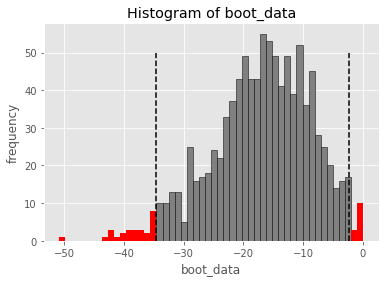

In [31]:
boot_means = get_bootstrap(
                    Control, 
                    Test, 
                    boot_it = 1000, 
                    statistic = np.mean)

In [15]:
# значение p-value
boot_means["p_value"]

0.03481436921999326

In [16]:
# ДИ
boot_means["quants"]

,0
0.025,-34.806868
0.975,-3.951723


В полученный доверительный интервал не попадает нулевое значение, а значит средние значение в тестовой и контрольной группах различаются на заданном уровне значимости. 

При верной нулевой гипотезе вероятность получить такое отклонение от нуля составляло бы меньше 5% (p-value < 0.05). Следовательно у нас есть основания отклонить нулевую гипотезу о равенстве средних в двух группах.

## Сравнение двух групп

In [17]:
# посмотрим насколько сильные различия в значениях между группами

In [18]:
differences = Control - Test
differences

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
          ...     
495    -989.026071
496   -1189.738926
497   -1491.219910
498   -1988.830922
499   -2988.500434
Name: value, Length: 500, dtype: float64

In [19]:
differences[differences != 0]

495    -989.026071
496   -1189.738926
497   -1491.219910
498   -1988.830922
499   -2988.500434
Name: value, dtype: float64

Различия в значениях наблюдаются только в 5 случаях. Причем в данных случаях значения в тестовой группе слишком высокие и являются выбросами.

In [20]:
# сравним средние теста и контроля

In [21]:
print(f"среднее в тесте: {np.mean(Test)}\n"
      f"среднее в контроле: {np.mean(Control)}")

среднее в тесте: 27.321499056661573
среднее в контроле: 10.026866533804297


Среднее в тесте больше среднего контрольной группы почти в 3 раза, т.к. выбросы значительно влияют на результат.

In [22]:
# сравним медианы

In [23]:
print(f"медиана в тесте: {np.median(Test)}\n"
      f"медиана в контроле: {np.median(Control)}")

медиана в тесте: 10.02584684253515
медиана в контроле: 10.0184651909296


 Медианы двух групп практически идентичны, так как медиана гораздо менее чувствительна к выбросам, чем среднее. 

Проведем тогда проверочный бутсрап медиан двух групп.

## Сравниваем медианы тестовой и контрольной группы с помощью Bootstrap

H0: Средние значения в группах не различаются
    
H1: Средние значения различаются

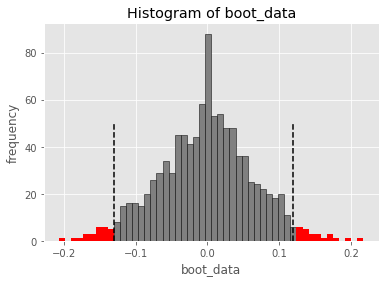

In [28]:
boot_median = get_bootstrap(
                    Control, 
                    Test, 
                    boot_it = 1000, 
                    statistic = np.median)

In [29]:
# значение p-value
boot_median["p_value"]

0.9713790853453922

In [30]:
# ДИ
boot_median["quants"]

,0
0.025,-0.130515
0.975,0.118762


В полученный доверительный интервал теперь попадает нулевое значение, а значит средние значение в тестовой и контрольной группах  не различаются на заданном уровне значимости. 

При верной нулевой гипотезе вероятность получить такое отклонение от нуля составляло бы больше 5% (p-value > 0.05). Следовательно у нас нет оснований отклонить нулевую гипотезу о равенстве средних в двух группах.

## ОБЩИЙ ВЫВОД

Данные в тестовой группе распределены ненормально и имеют сильные выбросы, в то время как данные в контрольной группе имеют нормальное распределение без выбросов. 

Из трех проведенных тестов только непараметрический U-критерий Манна-Уитни показал, что статистически значимых различий между критериями нет.
В то время как t-тест и бутстрап средних говорят о наличие статистически значимых различий. 

Следует принимать во внимание, что из данных тестов менее чувствителен к выбросам(экстремально большим или малым значениям) именно U-критерий Манна-Уитни,так как переводит данные в ранговую шкалу для оценки различий.
t-тест может быть использован для сравнения средних и при ненормальном распределении, особенно на больших выборках и если в данных нет заметных выбросов. Но в нашем случае как раз есть 5 экстремальных выбросов. Ошибочное использование t-критерия Стьюдента увеличивает вероятность выявить несущественные различия, то есть подтвердить недостоверную гипотезу. 
В случае бутстрапа было бы более верным решением сравнить с помощью этого метода медианы контрольной и тестовой групп, так как медианы менее чувствительны к выбросам, чем средние значения.

В данном случае стоит доверять результу U-критерия Манна-Уитни или бутстрапу медиан, а значит мы можем сделать вывод, что сравниваемые группы не имеют значимых различий, т.е. мы не стали больше зарабатывать с пользователя.